## Initialize

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import torch
import copy 
import seaborn as sn
import random
import pandas as pd
import seaborn as sns
import numpy as np

import torch.nn as nn
import torch.optim as optim
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import sklearn
from sklearn.metrics import confusion_matrix
sys.path.append('../third_party')
import pdb
from scipy.stats.mstats import mquantiles
  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available? {}".format(torch.cuda.is_available()))

sys.path.append('../')
from conformal_learning.bbox import BlackBox
from conformal_learning.split_conf import SplitConformal, evaluate_predictions, ProbAccum
from conformal_learning.auxiliary import eval_predictions, KL, cvm

Is CUDA available? False


# Load the data

Download the data file 'default of credit card clients.xls' from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients and place it in the current folder.

In [2]:
# pip install xlrd
df = pd.read_excel('default of credit card clients.xls')
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [3]:
Y = np.asarray(df.iloc[1:,24]).astype(int)
X_raw = np.asarray(df.iloc[1:,1:24]).astype(np.float32)
X = X_raw

## Set the random seeds

In [4]:
seed = 2
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
# Split the data to train, test, and hold-out sets

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

X_hout = X_train[int(0.8*X_train.shape[0]):,:]
Y_hout = Y_train[int(0.8*X_train.shape[0]):]

X_train = X_train[:int(0.8*X_train.shape[0]),:]
Y_train = Y_train[:int(0.8*Y_train.shape[0])]

X_tr_score = X_train[int(0.7*X_train.shape[0]):,:]
Y_tr_score = Y_train[int(0.7*X_train.shape[0]):]

X_train = X_train[:int(0.7*X_train.shape[0]),:]
Y_train = Y_train[:int(0.7*Y_train.shape[0])]

X_augmented = np.concatenate((X_train, X_tr_score),0)
Y_augmented = np.concatenate((Y_train, Y_tr_score),0)

num_classes = len(np.unique(Y))
num_features=X_train.shape[1]

## Train the models

In [6]:
# Train the model with CE loss

refit_model = False

file_final = 'saved_models_credit/saved_model_orig_'+'seed_'+str(seed)

if refit_model:
    box_ce = BlackBox(num_features, num_classes)
    stats_ce = box_ce.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout, 
                          batch_size=500, num_epochs=3000, lr=0.0001, mu=0, optimizer='Adam',
                          save_model=True, save_checkpoint_period = 1,
                          name=file_final, early_stopping=True,
                          name_CP='saved_models_credit/checkpoint_orig_'+str(seed))
else:
    print('Loading pre-trained model.')
    box_ce = BlackBox(num_features, num_classes)
    saved_stats = torch.load(file_final, map_location=device)
    box_ce.model.load_state_dict(saved_stats['model_state'])
    stats_ce = saved_stats['stats']

Loading pre-trained model.


In [7]:
# Download models with early stopping

# For early stopping loss
box_orig_ho_loss = BlackBox(num_features, num_classes)
saved_stats_ho_loss = torch.load('saved_models_credit/checkpoint_orig_'+'seed_'+str(seed)+'loss', map_location=device)
box_orig_ho_loss.model.load_state_dict(saved_stats_ho_loss['model_state'])

# For early stopping acc
box_orig_ho_acc = BlackBox(num_features, num_classes)
saved_stats_ho_acc = torch.load('saved_models_credit/checkpoint_orig_'+'seed_'+str(seed)+'acc', map_location=device)
box_orig_ho_acc.model.load_state_dict(saved_stats_ho_acc['model_state'])

<All keys matched successfully>

In [8]:
# Train the new model

refit_model = False
file_final = 'saved_models_credit/saved_model_new_'+'seed_'+str(seed)

Z_train = np.zeros(len(Y_train))
Z_tr_score = np.ones(len(Y_tr_score))
Z_augmented = np.concatenate((Z_train, Z_tr_score),0)

if refit_model:
    
    box_new = BlackBox(num_features, num_classes)
    stats_new = box_new.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout, cond_label=True,
                                Z_train=Z_augmented, 
                                batch_size=2500, num_epochs=6000, lr=0.0001,
                                mu=0.2, mu_size=0, alpha=0.2, optimizer='Adam',
                                save_model=True, save_checkpoint_period = 1,
                                name=file_final, early_stopping=True,
                                name_CP='saved_models_credit/checkpoint_new_'+'seed_'+str(seed))

else:
    print('Loading pre-trained model.')
    box_new = BlackBox(num_features, num_classes)
    saved_stats = torch.load(file_final, map_location=device)
    box_new.model.load_state_dict(saved_stats['model_state'])
    stats_new = saved_stats['stats']

Loading pre-trained model.


In [9]:
# Download models with early stopping

# For early stopping loss
box_new_ho_loss = BlackBox(num_features, num_classes)
saved_stats_new_loss = torch.load('saved_models_credit/checkpoint_new_'+'seed_'+str(seed)+'loss', map_location=device)
box_new_ho_loss.model.load_state_dict(saved_stats_new_loss['model_state'])

# For early stopping acc
box_new_ho_acc = BlackBox(num_features, num_classes)
saved_stats_new_acc = torch.load('saved_models_credit/checkpoint_new_'+'seed_'+str(seed)+'acc', map_location=device)
box_new_ho_acc.model.load_state_dict(saved_stats_new_acc['model_state'])

<All keys matched successfully>

In [10]:
# Train the hybrid model

file_final = 'saved_models_credit/saved_model_hybrid_'+'seed_'+str(seed)
refit_model = False

if refit_model:
    box_hybrid = BlackBox(num_features, num_classes)
    stats_hybrid = box_hybrid.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout,
                                Z_train=Z_augmented, cond_label=True,
                                batch_size=2500, num_epochs=4000, lr=0.0001,
                                mu=0, mu_size=0.1, alpha=0.2, 
                                save_model=True, save_checkpoint_period = 1, optimizer='Adam',
                                name=file_final, early_stopping=True, 
                                name_CP='saved_models_credit/checkpoint_hybrid_'+'seed_'+str(seed), verbose=True)

else:
    print('Loading pre-trained model.')
    box_hybrid = BlackBox(num_features, num_classes)
    saved_stats = torch.load(file_final, map_location=device)
    box_hybrid.model.load_state_dict(saved_stats['model_state'])
    stats_hybrid = saved_stats['stats']

Loading pre-trained model.


In [11]:
# Download models with early stopping

# For early stopping loss
box_hybrid_ho_loss = BlackBox(num_features, num_classes)
saved_stats_hybrid_loss = torch.load('saved_models_credit/checkpoint_hybrid_'+'seed_'+str(seed)+'loss', map_location=device)
box_hybrid_ho_loss.model.load_state_dict(saved_stats_hybrid_loss['model_state'])

# For early stopping acc
box_hybrid_ho_acc = BlackBox(num_features, num_classes)
saved_stats_hybrid_acc = torch.load('saved_models_credit/checkpoint_hybrid_'+'seed_'+str(seed)+'acc', map_location=device)
box_hybrid_ho_acc.model.load_state_dict(saved_stats_hybrid_acc['model_state'])

<All keys matched successfully>

In [12]:
# Train the model with focal loss

file_final = 'saved_models_credit/saved_model_FocalLoss_'+'seed_'+str(seed)

refit_model = False

if refit_model:
    box_fc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
    stats_fc = box_fc.fit(X_augmented, Y_augmented, X_hout=X_hout, Y_hout=Y_hout, 
                          batch_size=500, num_epochs=3000, lr=0.0001, mu=0,
                          save_model=True, save_checkpoint_period = 1, optimizer='Adam',
                          name=file_final, early_stopping=True, 
                          name_CP='saved_models_credit/checkpoint_FocalLoss_'+'seed_'+str(seed), verbose=True)


else:
    print('Loading pre-trained model.')
    box_fc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
    saved_stats = torch.load(file_final, map_location=device)
    box_fc.model.load_state_dict(saved_stats['model_state'])
    stats_fc = saved_stats['stats']

Loading pre-trained model.


In [13]:
# Download models with early stopping

# For early stopping loss
box_focal_ho_loss = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
saved_stats_ho_loss = torch.load('saved_models_credit/checkpoint_FocalLoss_'+'seed_'+str(seed)+'loss', map_location=device)
box_focal_ho_loss.model.load_state_dict(saved_stats_ho_loss['model_state'])

# For early stopping acc
box_focal_ho_acc = BlackBox(num_features, num_classes, base_loss='Focal', gamma=1)
saved_stats_ho_acc = torch.load('saved_models_credit/checkpoint_FocalLoss_'+'seed_'+str(seed)+'acc', map_location=device)
box_focal_ho_acc.model.load_state_dict(saved_stats_ho_acc['model_state'])

<All keys matched successfully>

## Training diagnostics

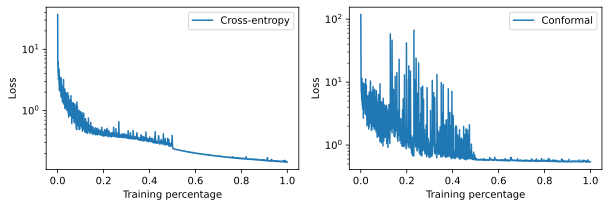

In [14]:
# Graph of the loss function computed on the training set

fig=plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["loss"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Loss")
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["loss"], label="Conformal")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Loss")
plt.yscale("log")

plt.show()

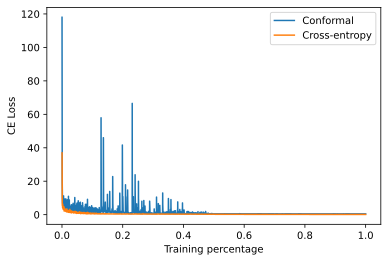

In [15]:
# Graph of CE loss computed on the training set

plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["pred"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["pred"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("CE Loss")
#plt.yscale("log")
plt.show()

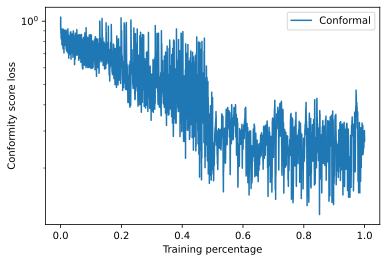

In [16]:
# Graph of the new conformity score loss function computed on the training set

plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["scores"], label="Conformal")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Conformity score loss")
plt.yscale("log")
plt.show()

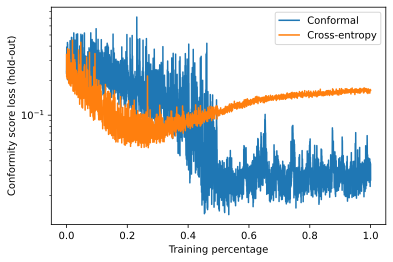

In [17]:
# Graph of the new conformity score loss function computed on the hold-out set

plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["scores-estop"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["scores-estop"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Conformity score loss (hold-out)")
plt.yscale('log')
plt.show()

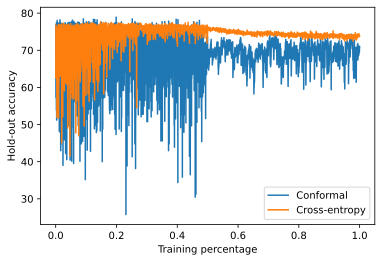

In [18]:
# Graph of the accuracy computed on the hold-out set

plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["acc-estop"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["acc-estop"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Hold-out accuracy")
plt.show()

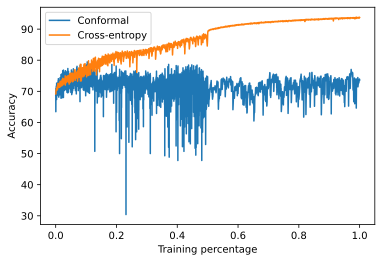

In [19]:
# Graph of the accuracy computed on the training set

plt.plot(stats_new["epoch"]/np.max(stats_new["epoch"]), stats_new["acc"], label="Conformal")
plt.plot(stats_ce["epoch"]/np.max(stats_ce["epoch"]), stats_ce["acc"], label="Cross-entropy")
plt.legend()
plt.xlabel("Training percentage")
plt.ylabel("Accuracy")
plt.show()

# Check results

## Predictive accuracy

In [20]:
eval_predictions(X_test, Y_test, box_ce, data="test (CE)")
eval_predictions(X_test, Y_test, box_new, data="test (Conformal)")

Classification error on test (CE) data: 26.8%
Classification error on test (Conformal) data: 29.8%


29.799999999999997

## Conformity scores on test data

Plotting conformity scores for Cross-Entropy model.


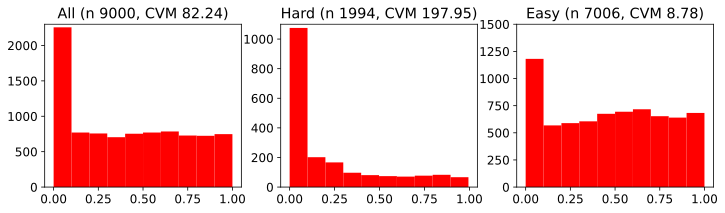

Plotting conformity scores for Conformal model.


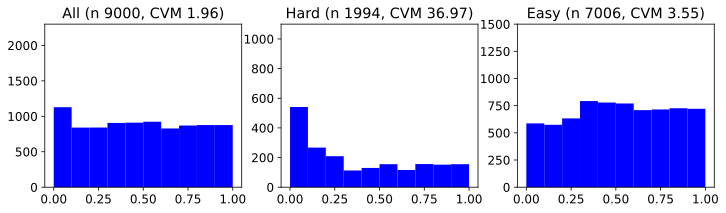

In [21]:
# Plot the conformity scores of different models

for plot_model in ["Cross-Entropy", "Conformal"]:

    if plot_model == "Cross-Entropy":
        bbox_plot = box_ce      # choose bbox to plot histogram of scores
        color = "red"
    elif plot_model == "Conformal":
        bbox_plot = box_new
        color = "blue"
    elif plot_model == "Focal":
        bbox_plot = box_fc 
        color = "yellow"
    elif plot_model == "Hybrid":
        bbox_plot = box_hybrid 
        color = "black"
        
    print("Plotting conformity scores for {:s} model.".format(plot_model))

    p_hat_test = bbox_plot.predict_proba(X_test)
    grey_box = ProbAccum(p_hat_test)
    epsilon_test = np.random.uniform(size=(len(Y_test,)))
    scores_test = grey_box.calibrate_scores(Y_test, epsilon=epsilon_test)

    easy_idx = np.asarray(np.where((Y_test==0)))[0,:]
    hard_idx = np.asarray(np.where((Y_test==1)))[0,:]

    fig=plt.figure(figsize=(12, 3))
    plt.rcParams['font.size'] = '12'
    plt.subplot(1, 3, 1)
    plt.hist(scores_test, color=color)
    plt.ylim([0,2300])
    plt.title("All (n {:d}, CVM {:.2f})".format(len(scores_test), cvm(scores_test)))

    plt.subplot(1, 3, 2)
    plt.hist(scores_test[hard_idx], color=color)
    plt.ylim([0,1100])
    plt.title("Hard (n {:d}, CVM {:.2f})".format(len(hard_idx), cvm(scores_test[hard_idx])))

    plt.subplot(1, 3, 3)
    plt.hist(scores_test[easy_idx], color=color)
    plt.ylim([0,1500])
    plt.title("Easy (n {:d}, CVM {:.2f})".format(len(scores_test)-len(hard_idx), cvm(scores_test[easy_idx])))
    plt.show()

## Split-conformal (evaluate)

In [22]:
# Show the conditional coverage, sizes and other results using split-conformal

if False:
    # Show results with full training
    black_boxes_names = ["Cross-entropy", "Conformal", "Focal", "Hybrid"]
    black_boxes = [box_ce, box_new, box_hybrid, box_fc]
    colors = ["red", "blue","yellow","black"]
else:
    # Show results with early stopping
    black_boxes_names = ["Cross-entropy", "Cross-entropy ES loss", "Cross-entropy ES acc",
                       "Conformal", "Conformal ES loss", "Conformal ES acc",
                       "Focal", "Focal ES loss", "Focal ES acc",
                       "Hybrid", "Hybrid ES loss", "Hybrid ES acc"]
    black_boxes = [box_ce, box_orig_ho_loss, box_orig_ho_acc, 
                 box_new, box_new_ho_loss, box_new_ho_acc,
                 box_hybrid, box_hybrid_ho_loss, box_hybrid_ho_acc,
                 box_fc, box_focal_ho_loss, box_focal_ho_acc]
    colors = ["red", "red", "red", "blue", "blue","blue", "yellow", "yellow", "yellow", "black", "black", "black"]

In [23]:
results = pd.DataFrame()

alpha = 0.2

from tqdm.notebook import tqdm

for e in tqdm(range(25)):

    X_calib, X_test_tmp, Y_calib, Y_test_tmp = train_test_split(X_test, Y_test, test_size=0.5, random_state=e)

    sc_methods = []
    for i in range(len(black_boxes)):
        # print("{:s}:".format(black_boxes_names[i]))
        sc_method = SplitConformal()
        sc_method.calibrate(X_calib, Y_calib, alpha, bbox=black_boxes[i], no_calib=False, print_alpha=False)
        sc_methods.append(sc_method)

    easy_idx = np.asarray(np.where((Y_test_tmp==0)))[0,:]
    hard_idx = np.asarray(np.where((Y_test_tmp==1)))[0,:]

    for k in range(len(black_boxes)):
        sets = sc_methods[k].predict(X_test_tmp)
        res = evaluate_predictions(sets, X_test_tmp, Y_test_tmp, hard_idx, conditional=True)

        res['Model'] = black_boxes_names[k]
        res['Experiment'] = e
        res['Error'] = eval_predictions(X_test_tmp, Y_test_tmp, black_boxes[k], data="test", plot=False, printing=False)

        results = pd.concat([results, res])

  0%|          | 0/25 [00:00<?, ?it/s]

In [24]:
results.groupby(['Model']).mean()

,Coverage,Conditional coverage,Size,Size (median),Size-hard,Size-easy,Size-hard (median),Size-easy (median),n-hard,n-easy,Size conditional on cover,Experiment,Error
Model,,,,,,,,,,,,,
Conformal,0.836062,0.607950,1.331476,1.0,1.424650,1.304937,1.0,1.0,997.2,3502.8,1.396382,12.0,29.762667
Conformal ES acc,0.801271,0.103383,1.096942,1.0,1.103383,1.095110,1.0,1.0,997.2,3502.8,1.120851,12.0,22.160000
Conformal ES loss,0.830400,0.586875,1.329431,1.0,1.409470,1.306640,1.0,1.0,997.2,3502.8,1.396645,12.0,30.065778
Cross-entropy,0.822631,0.547304,1.275529,1.0,1.352656,1.253570,1.0,1.0,997.2,3502.8,1.334860,12.0,26.632000
Cross-entropy ES acc,0.841787,0.400607,1.210711,1.0,1.339984,1.173875,1.0,1.0,997.2,3502.8,1.250278,12.0,23.374222
Cross-entropy ES loss,0.843031,0.498597,1.283093,1.0,1.392566,1.251946,1.0,1.0,997.2,3502.8,1.335711,12.0,25.201778
Focal,0.830809,0.472639,1.253760,1.0,1.363745,1.222445,1.0,1.0,997.2,3502.8,1.305373,12.0,25.624000
Focal ES acc,0.799049,0.106123,1.052658,1.0,1.105685,1.037601,1.0,1.0,997.2,3502.8,1.065807,12.0,22.466667
Focal ES loss,0.831636,0.537619,1.281191,1.0,1.389023,1.250485,1.0,1.0,997.2,3502.8,1.338051,12.0,26.891556


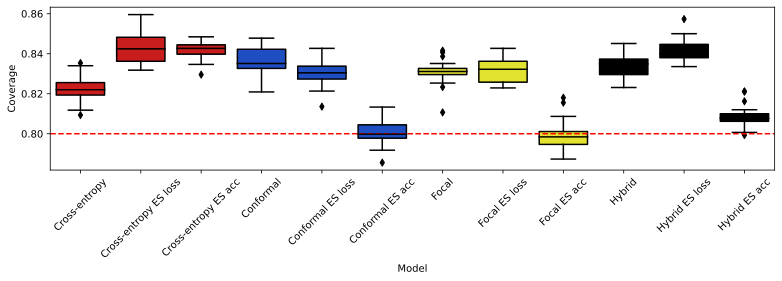

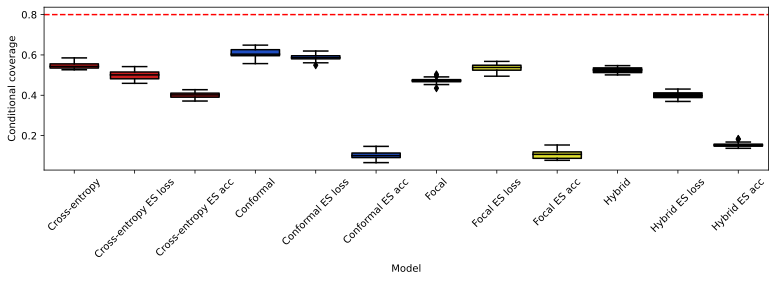

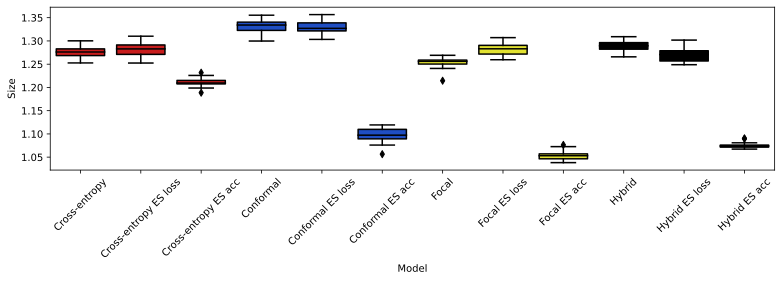

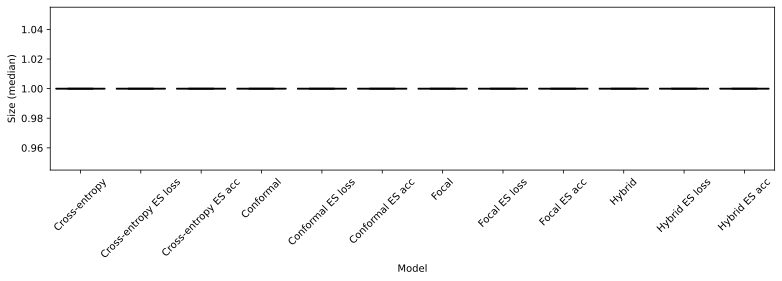

In [25]:
sn.reset_orig()
sns.set_palette(sns.xkcd_palette(colors))

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Coverage')
g.set_xticklabels(black_boxes_names, rotation=45)
plt.axhline(1-alpha, color='red', linestyle='dashed')
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Conditional coverage')
g.set_xticklabels(black_boxes_names, rotation=45)
plt.axhline(1-alpha, color='red', linestyle='dashed')
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Size')
g.set_xticklabels(black_boxes_names, rotation=45)
#plt.ylim(0.5,2)
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(13, 3)
g = sns.boxplot(data = results, ax=ax, x = 'Model', y = 'Size (median)')
g.set_xticklabels(black_boxes_names, rotation=45)
#plt.ylim(0.5,2)
plt.show()